# epymorph live demo

This is a demo of epymorph usage, showing off some of its flexibility in running simulations.

## Example 1: run SIRS with commuter movement in 6 US states

Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.312s


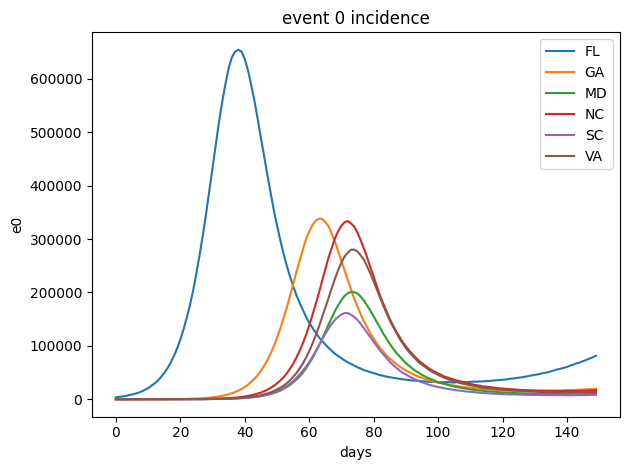

In [1]:
from datetime import date

import matplotlib.pyplot as plt
import numpy as np

from epymorph.context import SimContext
from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.geo import filter_geo
from epymorph.initializer import (_default_compartments, single_location,
                                  top_locations)
from epymorph.run import plot_event
from epymorph.simulation import Simulation, with_fancy_messaging

ipm1 = ipm_library['sirs']()
geo1 = geo_library['pei']()
mm1 = mm_library['pei']()

sim1 = with_fancy_messaging(Simulation(geo1, ipm1, mm1))

param1 = {
    # IPM params
    'beta': 0.35,
    'gamma': 1/6,
    'xi': 1/90,

    # MM params
    'theta': 0.1,
    'move_control': 0.9,
}


def init1(ctx: SimContext):
    return single_location(ctx, location=0, seed_size=10_000)


out1 = sim1.run(
    param=param1,
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init1
)

S_TO_I_EVENT = 0

plot_event(out1, S_TO_I_EVENT)

## Example 2: what if beta changes by time and location?

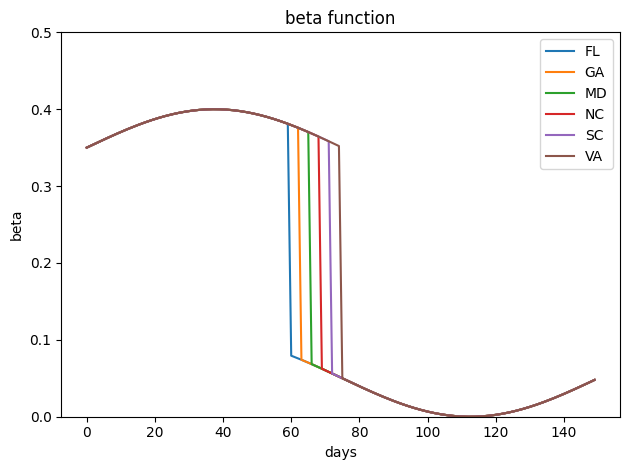

In [2]:
days = 150
t = np.arange(0, 1, 1 / days)


def beta_fn(node):
    cutoff = 60 + (node * 3)
    return (0.35 + 0.05 * np.sin(2 * np.pi * t)) - \
        (0.3 * np.concatenate((np.zeros(cutoff), np.ones(days - cutoff))))


time_varying_beta = np.array([beta_fn(n) for n in range(geo1.nodes)]).T


def plot_beta():
    fig, ax = plt.subplots()
    ax.set_title('beta function')
    ax.set_ylabel('beta')
    ax.set_xlabel('days')
    ax.set_ylim(ymin=0, ymax=0.5)
    ax.plot(np.arange(150), time_varying_beta, label=geo1.labels)
    ax.legend()
    fig.tight_layout()
    plt.show()


plot_beta()

Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.305s


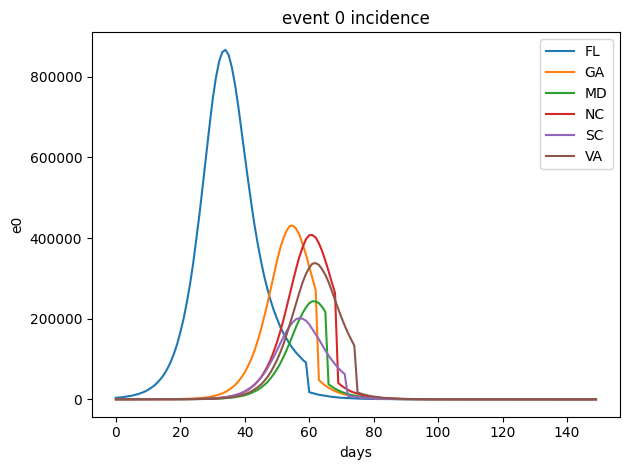

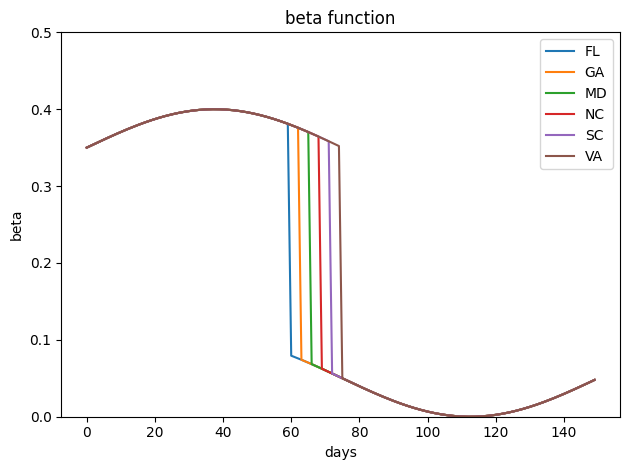

In [3]:
param2 = param1 | {
    'beta': time_varying_beta,
}

out2 = sim1.run(
    param=param2,
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init1
)

plot_event(out2, S_TO_I_EVENT)
plot_beta()

## Example 3: different initialization, same beta

Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.312s


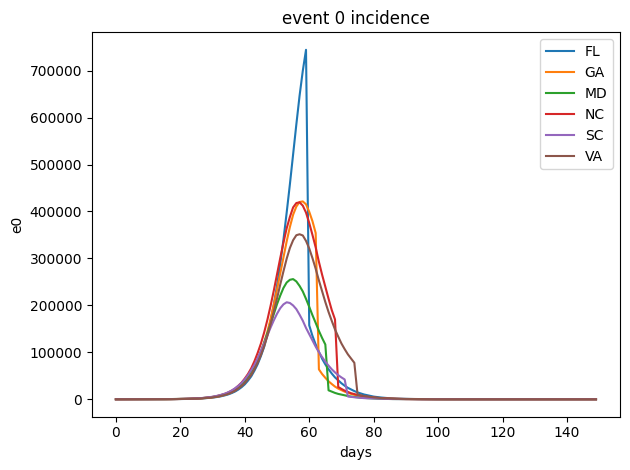

In [4]:
def init3(ctx: SimContext):
    cs = _default_compartments(ctx)
    cs[:, 0] -= 30
    cs[:, 1] += 30
    return cs


out3 = sim1.run(
    param=param2,
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init3
)

plot_event(out3, S_TO_I_EVENT)

## Example 4: swap in an SIRH model

Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.368s


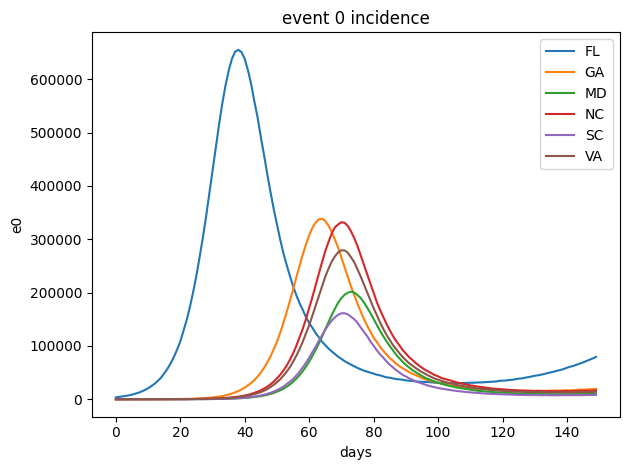

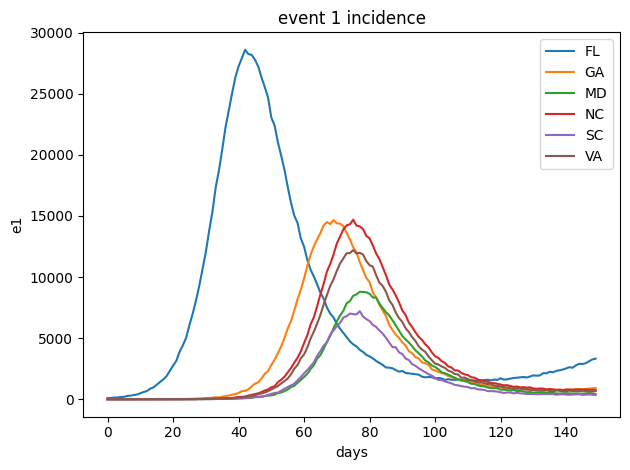

In [5]:
ipm4 = ipm_library['sirh']()

sim4 = with_fancy_messaging(Simulation(geo1, ipm4, mm1))

param4 = {
    # IPM params
    'beta': 0.35,
    'gamma': 1/6,
    'xi': 1/90,
    'hospitalization_rate': 0.05,
    'hospitalization_duration': 14.0,

    # MM params
    'theta': 0.1,
    'move_control': 0.9,
}

out4 = sim4.run(
    param=param4,
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init1
)

S_TO_I_EVENT = 0
I_TO_H_EVENT = 1

plot_event(out4, S_TO_I_EVENT)
plot_event(out4, I_TO_H_EVENT)

## Example 5: swap out the GEO

Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 48 geo nodes
|####################| 100% 
Runtime: 3.071s


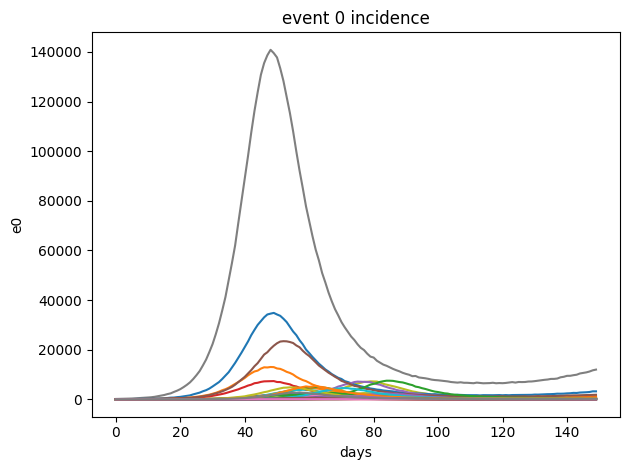

In [6]:
# Let's use just Arizona and New Mexico counties
us_counties = geo_library['us_counties_2015']()

selection = np.where([
    geoid.startswith('04') or geoid.startswith('35')
    for geoid in us_counties.data['geoid']
])[0]

geo5 = filter_geo(us_counties, selection)

mm5 = mm_library['pei']()
sim5 = with_fancy_messaging(Simulation(geo5, ipm4, mm5))


def init5(ctx: SimContext):
    return top_locations(ctx, attribute='population', num_locations=5, seed_size=500)


out5 = sim5.run(
    param=param4,
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init5
)

plot_event(out5, S_TO_I_EVENT)